In [1]:
import tensorflow as tf 
import numpy as np 
import time
import seaborn as sns

from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint 
from keras.datasets.mnist import load_data 
from tensorflow.keras.optimizers import Adam
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Lambda, Activation
from matplotlib import pyplot as plt 
from keras import backend as K 
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix

In [2]:
def Generator(latent_dim):
    in_lat = Input(shape=(latent_dim, ))
    n_nodes = 256 * 7 * 7
    X = Dense(n_nodes)(in_lat)
    X = LeakyReLU(alpha=0.2)(X)
    X = Reshape((7, 7, 256))(X)
    X = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)
    X = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)
    out_layer = Conv2DTranspose(1, (3, 3), strides=(2, 2), activation='tanh', padding='same')(X)
    
    model = Model(in_lat, out_layer)
    return model

def Discriminator(in_shape=(28, 28, 1), num_classes=10):
    in_image = Input(shape=in_shape)
    X = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(in_image)
    X = LeakyReLU(alpha=0.2)(X)
    X = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)
    X = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)
    X = Flatten()(X)
    X = Dropout(0.4)(X)
    X = Dense(num_classes)(X)
    
    model = Model(inputs=in_image, outputs=X)
    return model

def Sup_Discriminator(disc):
    model = Sequential()
    model.add(disc)
    model.add(Activation('softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model 

def custom_activation(x):
    Z_x = K.sum(K.exp(x), axis=-1, keepdims=True)
    D_x = Z_x / (Z_x + 1)
    return D_x

def Unsup_Discriminator(disc):
    model = Sequential()
    model.add(disc)
    model.add(Lambda(custom_activation))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999))
    return model 

In [3]:
def GAN(gen_model, disc_unsup):
    disc_unsup.trainable = False
    gan_output = disc_unsup(gen_model.output)
    model = Model(gen_model.input, gan_output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999))
    return model

In [4]:
def load_real_samples(num_classes=10):
    (train_X, train_y), (_, _) = load_data()
    X = expand_dims(train_X, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5 
    print(X.shape, train_y.shape)
    return [X, train_y]

def select_supervised_samples(dataset, n_samples=1000, num_classes=10):
    X, y = dataset 
    X_list, y_list = list(), list()
    n_per_class = int(n_samples / num_classes)
    for i in range(num_classes):
        X_with_class = X[y == i]
        idx = randint(0, len(X_with_class), n_per_class)
        [X_list.append(X_with_class[j]) for j in idx]
        [y_list.append(i) for j in idx]
        return asarray(X_list), asarray(y_list)
    
def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    idx = randint(0, images.shape[0], n_samples)
    X, labels = images[idx], labels[idx]
    y = ones((n_samples, 1))
    return [X, labels], y

def generate_latent_points(latent_dim, n_samples):
    z_input = randn(latent_dim * n_samples)
    z_input = z_input.reshape(n_samples, latent_dim)
    return z_input

def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    fake_images = generator.predict(z_input)
    y = zeros((n_samples, 1))
    return fake_images, y

def summarize_performance(step, gen_model, disc_sup, latent_dim, dataset, n_samples=100):
    X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)
    X = (X + 1) / 2.0 
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        plt.axis('off')
        plt.imshow(X[i, :, :, 0], cmap='gray_r')
    filename1 = './SGAN_Generate/images/generated_plot_%05d.png' % (step + 1)
    plt.savefig(filename1)
    filename2 = './SGAN_Generate/gen_model/gen_model_%05d.h5' % (step + 1)
    gen_model.save(filename2)
    filename3 = './SGAN_Generate/disc_sup_model/disc_sup_%05d.h5' % (step + 1)
    disc_sup.save(filename3)
    print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [5]:
def train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=50, n_batch=100):
    X_sup, y_sup = select_supervised_samples(dataset)
    
    batch_per_epoch = int(dataset[0].shape[0] / n_batch)
    n_steps = batch_per_epoch * n_epochs 
    half_batch = int(n_batch / 2)
    
    # print(batch_per_epoch)
    
    for i in tqdm(range(n_steps), total=n_steps):
        [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
        sup_loss, sup_acc = disc_sup.train_on_batch(Xsup_real, ysup_real)
        
        [X_real, _], y_real = generate_real_samples(dataset, half_batch)
        d_loss_real = disc_unsup.train_on_batch(X_real, y_real)
        
        X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
        d_loss_fake = disc_unsup.train_on_batch(X_fake, y_fake)
        
        X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
        gan_loss = gan_model.train_on_batch(X_gan, y_gan)
        
        clear_output()
        # time.sleep(0.1)
        
        if (i + 1) % 100 == 0:
            print('>%d, c[%.3f, %.0f], d[%.3f, %.3f], g[%.3f]' % (i + 1, sup_loss, sup_acc * 100, d_loss_real, d_loss_fake, gan_loss))
            
        if (i + 1) % batch_per_epoch == 0:
            summarize_performance(i, gen_model, disc_sup, latent_dim, dataset)

In [6]:
latent_dim = 100
disc = Discriminator()
disc_sup = Sup_Discriminator(disc)
disc_unsup = Unsup_Discriminator(disc)

gen_model = Generator(latent_dim)
gan_model = GAN(gen_model, disc_unsup)
dataset = load_real_samples()

# train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=30, n_batch=100)

(60000, 28, 28, 1) (60000,)


In [7]:
disc_sup_trained_model = load_model('./SGAN_Generate/disc_sup_model/disc_sup_17400.h5')

(_, _), (X_test, y_test) = load_data()

X_test = expand_dims(X_test, axis=-1)
X_test = X_test.astype('float32')
X_test = (X_test - 127.5) / 127.5 

# _, test_acc = disc_sup_trained_model.evaluate(X_test, y_test, verbose=0)
# print('Test Accuracy: %.3f%%' % (test_acc * 100))

# y_pred = disc_sup_trained_model.predict(X_test)
# y_pred = np.argmax(y_pred, axis=1)
# print(y_pred[:100])

1/1 [==============================] - 0s 383ms/step


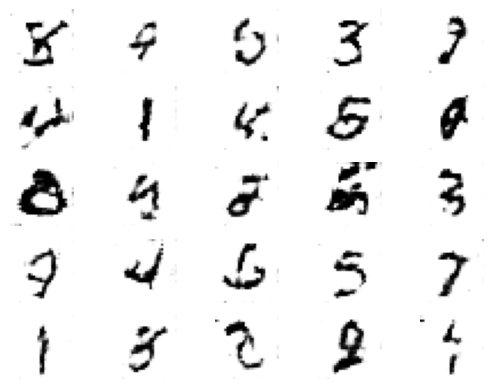

In [8]:
def show_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :], cmap='binary')
    plt.show()

gen_trained_model = load_model('./SGAN_Generate/gen_model/gen_model_18000.h5', compile=False)
latent_points = generate_latent_points(100, 25)

X = gen_trained_model.predict(latent_points)
X = (X + 1) / 2.0
X = (X * 255).astype(np.uint8)
show_plot(X, 5)